# Examining individual Monte Carlo results

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib as mpl

mpl.rcParams['font.size'] = 20.0

from scipy.integrate import simps, cumtrapz
from scipy.interpolate import interp1d
from scipy.stats import iqr

import matplotlib.pyplot as plt

import sys
sys.path.append('../')

import perturbations as PB
import dirs
dist_dir = dirs.data_dir + "distributions/"

In [3]:
M_min = 3.3e-19
M_max = 5.1e-5
def dNdM(Mlist, gamma=1.7):
    return ((1-gamma)*Mlist**(-gamma))/(M_max**(1-gamma)-M_min**(1-gamma))

In [4]:
import AMC

1.164e+02, 1.778e+10
2.117e+05
1.5456911788188752


#### AMC properties

Looking at histograms of $M_\mathrm{MC}$, $R_\mathrm{MC}$ and $\rho_{\mathrm{MC}}$...

In [5]:
def r_AS(M_AMC):
    m_a = 2e-5
    m_22 = m_a/1e-22
    return 1e3*(1.6/m_22)*(M_AMC/1e9)**(-1/3)

In [8]:
#Specify the radius you'd like to investigate (in pc)
Rstr = "6.96"
PROFILE = "NFW"
#Rstr = "0.65"

In [9]:
#Load properties from the Monte Carlo results file
M_i, R_i, D_i, M_f, R_f, D_f, e, psi  = np.loadtxt(dirs.montecarlo_dir + "AMC_logflat_a=" + Rstr + "_" + PROFILE + ".txt", unpack=True, delimiter=',')
V_i = (4/3)*np.pi*R_i**3
V_f = (4/3)*np.pi*R_f**3
rho_i = M_i/V_i
rho_f = M_f/V_f

mask = M_f > 1e-29

Survival probability: 0.90839
3.2861280133254484e-19
1.2924679430184007e-24


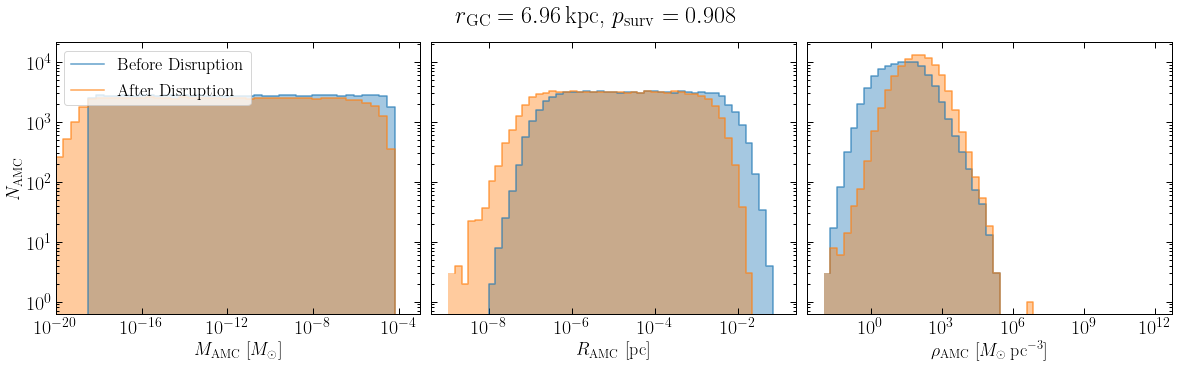

In [10]:
N_i = np.sum([M_i > 1e-25])
N_f = np.sum([M_f > 1e-25])

p_surv = N_f/N_i
print("Survival probability:", p_surv)
a_plot = 0.7
a_hist = 0.4

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(20,5), gridspec_kw={'wspace': 0.03})
fig.suptitle(r"$r_\mathrm{GC} = " + Rstr + "\,\mathrm{kpc}$, $p_\mathrm{surv} = %.3f$"%(p_surv,))


# Plot one
# M_bins = np.geomspace(1e-20, 1e-5, 50)
# plt.figure(figsize=(7,5))
counts, edges, patches = ax1.hist(M_i, bins=np.geomspace(1e-22, 1e-3, 50), alpha=a_hist)
ax1.step(edges[1:], counts, color='C0', alpha=a_plot, label='Before Disruption')
counts, edges, patches = ax1.hist(M_f, bins=np.geomspace(1e-22, 1e-3, 50), alpha=a_hist)
ax1.step(edges[1:], counts, color='C1', alpha=a_plot, label='After Disruption')

# ax1.hist(M_i, alpha = a_plot, range=np.geomspace(1e-19, 1e-5, 50), bins=M_bins, label='Before Disruption')
# ax1.hist(M_f, alpha = a_plot, range=np.geomspace(1e-19, 1e-5, 50), bins=M_bins, label='After Disruption')

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel(r"$M_\mathrm{AMC}$ $[M_\odot]$")
ax1.set_ylabel(r"$N_\mathrm{AMC}$")
ax1.set_xlim(1e-20, 1e-3)

ax1.legend(loc='upper left')

# Plot two
counts, edges, patches = ax2.hist(R_i[mask], bins=np.geomspace(1e-9, 1e-1, 50), alpha=a_hist)
ax2.step(edges[1:], counts, color='C0', alpha=a_plot)
counts, edges, patches = ax2.hist(R_f[mask], bins=np.geomspace(1e-9, 1e-1, 50), alpha=a_hist)
ax2.step(edges[1:], counts, color='C1', alpha=a_plot)

# ax2.hist(R_i, alpha = a_plot, bins=np.geomspace(1e-9, 1e-3, 50))
# ax2.hist(R_f, alpha = a_plot, bins=np.geomspace(1e-9, 1e-3, 50))

ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel(r"$R_\mathrm{AMC}$ $[\mathrm{pc}]$")
# ax2.set_xlim(1e-9, 1e-3)
# plt.ylabel("$N_\mathrm{AMC}$")

print(np.min(M_i))
print(np.min(M_f[M_f > 1e-28]))
# Plot three
counts, edges, patches = ax3.hist(rho_i[mask], bins=np.geomspace(1e-2, 1e12, 50), alpha=a_hist)
ax3.step(edges[1:], counts, color='C0', alpha=a_plot)
counts, edges, patches = ax3.hist(rho_f[mask], bins=np.geomspace(1e-2, 1e12, 50), alpha=a_hist)
ax3.step(edges[1:], counts, color='C1', alpha=a_plot)

# ax3.hist(rho_i, alpha = a_plot, bins=np.geomspace(1e4, 1e10, 50))
# ax3.hist(rho_f, alpha = a_plot, bins=np.geomspace(1e4, 1e10, 50))

ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_xlabel(r"$\rho_\mathrm{AMC}$ $[M_\odot\,\mathrm{pc}^{-3}]$")
# ax3.set_xlim(1e4, 1e10)
plt.show()

#plt.savefig("../plots/Distributions_PL_r="+Rstr+"kpc.pdf", bbox_inches='tight')

#### Plot the distributions P(X), for the mass, radius and density

In [9]:
#Calculate masses and radii which don't pass the AS cut

delta_range = np.geomspace(0.1, 20, 100)
M_threshold = 0.0*delta_range

for i, delta in enumerate(delta_range):
    minicluster = AMC.AMC(M = 1e-10, delta=delta, profile="NFW")
    R0_AMC = minicluster.R
    R0_AS = r_AS(1e-10)
    M_threshold[i] = 1e-10*(R0_AS/R0_AMC)**(3/2)
    
print(np.min(M_threshold))

1.6478454017131668e-18


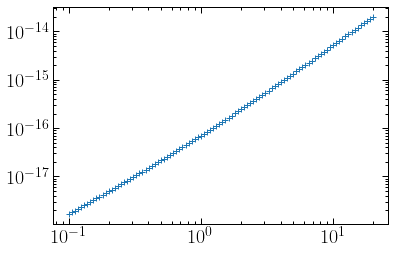

In [10]:
plt.figure()
plt.loglog(delta_range, M_threshold, "+")
plt.show()

In [11]:
M_range = np.geomspace(1e-19, 1e-10, 100)
R_threshold = 0.0*M_range

for i, M in enumerate(M_range):
    R_threshold[i] = r_AS(M)

Survival probability: 0.90839
1.0455032892876344


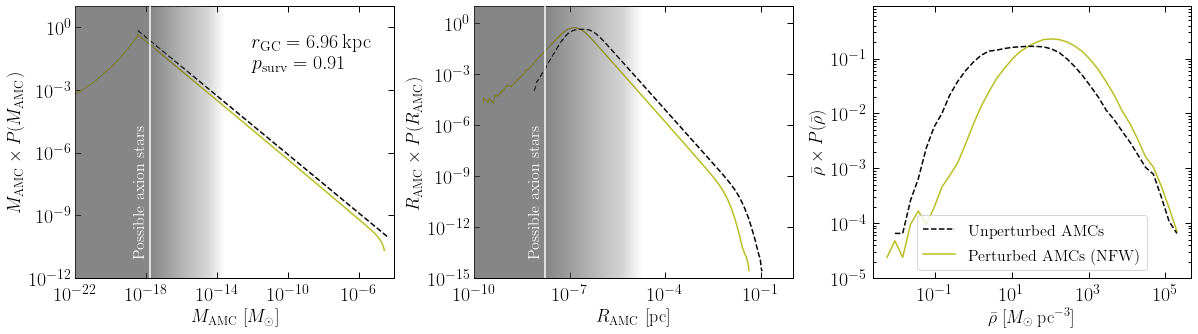

In [12]:
AS_CUT = False
if (AS_CUT):
    cut_text = "_AScut"
else:
    cut_text = ""
    
IDstr = "_wStripping"

M_f_true, P_M_f_true = np.loadtxt(dist_dir + "distribution_mass_" + Rstr + "_" + PROFILE + "_circ%s%s.txt"%(cut_text,IDstr), unpack=True, delimiter=',')
R_f_true, P_R_f_true = np.loadtxt(dist_dir + "distribution_radius_" + Rstr + "_" + PROFILE+ "_circ%s%s.txt"%(cut_text,IDstr), unpack=True, delimiter=',', usecols=(0,1))
R_i_true, P_R_i_true = np.loadtxt(dist_dir + "distribution_radius_" + PROFILE + "_circ%s_unperturbed%s.txt"%(cut_text,IDstr), unpack=True, delimiter=',', usecols=(0,1))

Mlist = np.geomspace(3.28433664535169e-19, 5.113402976492e-05, 100)

V_i = (4/3)*np.pi*R_i**3
V_f = (4/3)*np.pi*R_f**3
rho_i = M_i/V_i
rho_f = M_f/V_f


N_i = np.sum([M_i > 1e-25])
N_f = np.sum([M_f > 1e-25])

p_surv = N_f/N_i
print("Survival probability:", p_surv)
a_plot = 0.7
a_hist = 0.4
xpad=8

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(20,5), gridspec_kw={'wspace': 0.25})
# fig.suptitle(r"$r_\mathrm{GC} = " + Rstr + "\,\mathrm{kpc}$, $p_\mathrm{surv} = %.3f$"%(p_surv,))


# Plot one
# M_bins = np.geomspace(1e-20, 1e-5, 50)
# plt.figure(figsize=(7,5))
# print(M_i.min(), M_f.min())
# Mbins = np.geomspace(M_i.min(), M_i.max(), 50)
# print(M_i.min(), M_i.max())
# logwidth = np.diff(np.log10(Mbins))[0]
# Mbins = np.append(Mbins, Mbins[-1]*(10**logwidth))
# Mbins = np.insert(Mbins, 0, Mbins[0]/(10**logwidth))
# Mbins = np.insert(Mbins, 0, Mbins[0]/(10**logwidth))
# Mbins = np.insert(Mbins, 0, Mbins[0]/(10**logwidth))

cbefore = 'k'
if (PROFILE == "PL"):
    cafter = 'C0'
else:
    cafter = 'C8'



ax1.plot(M_f_true[P_M_f_true>1e-30], M_f_true[P_M_f_true>1e-30]*P_M_f_true[P_M_f_true>1e-30], color=cafter)
ax1.plot(Mlist, Mlist*dNdM(Mlist), ls='--', color=cbefore)
print(np.trapz(dNdM(Mlist), x=Mlist))

alpha_val = 0.01

for i,M_t in enumerate(M_threshold):
    ax1.axvspan(1e-22, M_t, color='grey', alpha=alpha_val, zorder=6)

ax1.axvline(np.min(M_threshold), color='w', linestyle='-', zorder=6)
ax1.text(0.18, 0.08, "Possible axion stars", color='white', rotation=90, transform=ax1.transAxes, fontsize=16, zorder=7)

# ax1.hist(M_i, alpha = a_plot, range=np.geomspace(1e-19, 1e-5, 50), bins=M_bins, label='Before Disruption')
# ax1.hist(M_f, alpha = a_plot, range=np.geomspace(1e-19, 1e-5, 50), bins=M_bins, label='After Disruption')


ax1.text(0.55, 0.9, "$r_\\mathrm{GC} = " + Rstr + "\\,\\mathrm{kpc}$\n$p_\\mathrm{surv} = %.2f$"%(p_surv,),transform=ax1.transAxes, ha='left', va='top')
ax1.xaxis.set_tick_params(pad=xpad)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel(r"$M_\mathrm{AMC}$ $[M_\odot]$")
# ax1.set_ylabel(r"$N_\mathrm{AMC}$")
ax1.set_ylabel(r"$M_\mathrm{AMC} \times P(M_\mathrm{AMC})$")
ax1.set_xlim(1e-22, 1e-4)
ax1.set_ylim(1e-12, 10)




# Plot two
# counts, edges, patches = ax2.hist(R_i, bins=np.geomspace(1e-8, 1e0, 50), alpha=a_hist, density=True)
# ax2.step(edges[1:], counts, color='C0', alpha=a_plot)
# counts, edges, patches = ax2.hist(R_f, bins=np.geomspace(1e-8, 1e0, 50), alpha=a_hist, density=True)
# ax2.step(edges[1:], counts, color='C1', alpha=a_plot)
# ax2.plot(R_f_true[P_R_f_true>0.0], P_R_f_true[P_R_f_true>0.0], label='After Disruption', ls='--')
ax2.plot(R_f_true[P_R_f_true>1e-30], R_f_true[P_R_f_true>1e-30]*P_R_f_true[P_R_f_true>1e-30], color=cafter)
ax2.plot(R_i_true[P_R_i_true>1e-30], R_i_true[P_R_i_true>1e-30]*P_R_i_true[P_R_i_true>1e-30], ls='--', color=cbefore)

# ax2.hist(R_i, alpha = a_plot, bins=np.geomspace(1e-9, 1e-3, 50))
# ax2.hist(R_f, alpha = a_plot, bins=np.geomspace(1e-9, 1e-3, 50))

ax2.xaxis.set_tick_params(pad=xpad)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel(r"$R_\mathrm{AMC}$ $[\mathrm{pc}]$")
ax2.set_ylabel(r"$R_\mathrm{AMC} \times P(R_\mathrm{AMC})$")



ax2.set_ylim(1e-15, 10)

for i,R_t in enumerate(R_threshold):
    ax2.axvspan(1e-22, R_t, color='grey', alpha=alpha_val, zorder=6)

ax2.axvline(np.min(R_threshold), color='w', linestyle='-', zorder=6)
ax2.text(0.17, 0.08, "Possible axion stars", color='white', rotation=90, transform=ax2.transAxes, fontsize=16, zorder=7)
    
ax2.set_xlim(1e-10, 1)
# plt.ylabel("$N_\mathrm{AMC}$")

# Plot three
# counts, edges, patches = ax3.hist(rho_i, bins=np.geomspace(1e-4, 1e6, 50), alpha=a_hist, density=True)
# ax3.step(edges[1:], counts, color='C0', alpha=a_plot)
# counts, edges, patches = ax3.hist(rho_f, bins=np.geomspace(1e-4, 1e6, 50), alpha=a_hist, density=True)
# ax3.step(edges[1:], counts, color='C1', alpha=a_plot)

counts, edges = np.histogram(rho_f, bins=np.geomspace(1e-4, 1e6, 50), density=True)
b_c = edges[:-1] + np.diff(edges)/2
ax3.plot(b_c[counts>0], b_c[counts>0]*counts[counts>0], color=cafter)
counts, edges = np.histogram(rho_i, bins=np.geomspace(1e-4, 1e6, 50), density=True)
b_c = edges[:-1] + np.diff(edges)/2
ax3.plot(b_c[counts>0], b_c[counts>0]*counts[counts>0], color=cbefore, ls='--')

# ax3.hist(rho_i, alpha = a_plot, bins=np.geomspace(1e4, 1e10, 50))
# ax3.hist(rho_f, alpha = a_plot, bins=np.geomspace(1e4, 1e10, 50))

ax3.xaxis.set_tick_params(pad=xpad)
ax3.yaxis.set_tick_params(pad=6)
ax3.set_ylabel(r"$\bar{\rho} \times P(\bar{\rho} )$")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_xlabel(r"$\bar{\rho}$ $[M_\odot\,\mathrm{pc}^{-3}]$")
ax3.set_ylim(1e-5, 0.9)

ax3.plot([0], [0], ls='--', label='Unperturbed AMCs', color=cbefore)
ax3.plot([0], [0], label='Perturbed AMCs (' + PROFILE + ')', color=cafter)
ax3.legend(loc='best', fontsize=16)

#ax3.legend(loc='best')
Rstr_pc = str(int(float(Rstr)*1000))
plt.savefig("../../plots/Distributions_" + PROFILE + "_r"+Rstr_pc+"pc%s%s.pdf"%(cut_text,IDstr), bbox_inches='tight')